In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy,tokenizer
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel,TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
data=pd.read_csv('/content/fake_news_data.csv')

In [ ]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

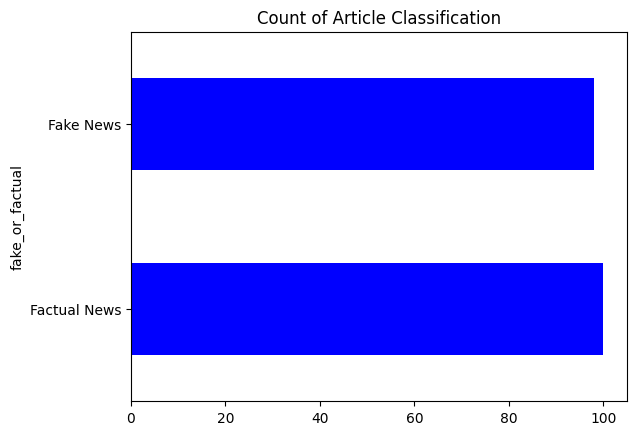

In [ ]:
data['fake_or_factual'].value_counts().plot(kind='barh',color='blue')
plt.title('Count of Article Classification')

**POS TAGGING**

In [ ]:
nlp=spacy.load('en_core_web_sm')

In [ ]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [ ]:
fake_spacy_docs = list(nlp.pipe(fake_news['text']))
fact_spacy_docs = list(nlp.pipe(fact_news['text']))

In [ ]:
def extract_token_tags(docs:spacy.tokens.doc.Doc):
  return [(i.text,i.ent_type_,i.pos_) for i in doc]

In [ ]:
fake_tagsdf = []
columns = ['token','ner_tag','pos_tag']

In [ ]:
for ix,doc in enumerate(fake_spacy_docs):
  tags = extract_token_tags(doc)
  tags = pd.DataFrame(tags,columns=columns)
  fake_tagsdf.append(tags)

In [ ]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [ ]:
fact_tagsdf = []

for ix,doc in enumerate(fact_spacy_docs):
  tags = extract_token_tags(doc)
  tags = pd.DataFrame(tags,columns=columns)
  fact_tagsdf.append(tags)

In [ ]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [ ]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [ ]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [ ]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [ ]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head()

,token
pos_tag,
NOUN,2597
VERB,1814
PROPN,1657
ADJ,876
ADV,412


In [ ]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2182
VERB,1535
PROPN,1387
ADJ,753
ADV,271
NUM,203
PRON,81
ADP,70
AUX,44


In [ ]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [ ]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


NAMED ENTITIES

In [ ]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

In [ ]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

In [ ]:
ner_palette = {
    'ORG': sns.color_palette()[0],
    'GPE': sns.color_palette()[1],
    'NORP': sns.color_palette()[2],
    'PERSON': sns.color_palette()[3],
    'DATE': sns.color_palette()[4],
    'CARDINAL': sns.color_palette()[5],
    'PERCENT': sns.color_palette()[6],

}

[Text(0.5, 1.0, 'Top 10 Named Entities in Fake News')]

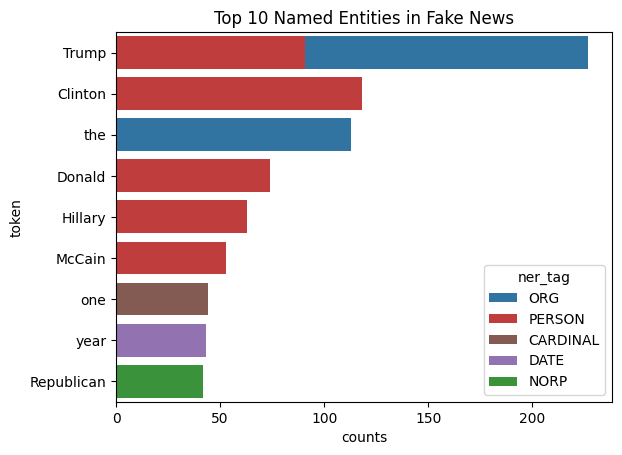

In [ ]:
sns.barplot(
    x='counts',y='token',hue='ner_tag',
    data=top_entities_fake[:10],
    palette=ner_palette,
    orient='h',
    dodge=False
).set(title='Top 10 Named Entities in Fake News')

[Text(0.5, 1.0, 'Top 10 Named Entities in Fact News')]

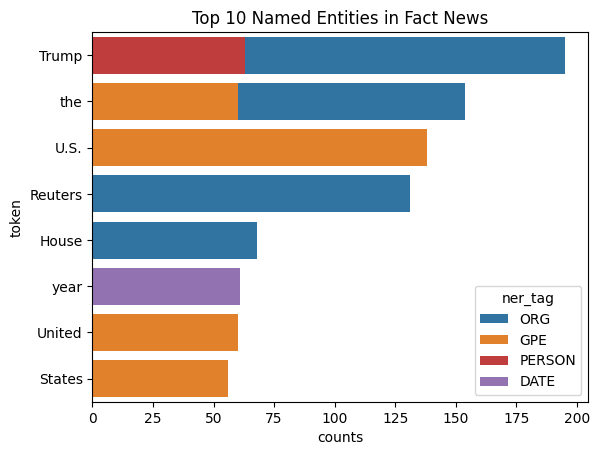

In [ ]:
sns.barplot(
    x='counts',y='token',hue='ner_tag',
    data=top_entities_fact[:10],
    palette=ner_palette,
    orient='h',
    dodge=False
).set(title='Top 10 Named Entities in Fact News')

TEXT PRE-PROCESS

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [ ]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "",x['text']),axis=1)

In [ ]:
data['text_clean']=data['text_clean'].str.lower()

In [ ]:
data['text_clean'] = data.apply(lambda x : re.sub(r"([^\w\s])","",x['text_clean']),axis=1)

In [ ]:
en_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['text_clean']=data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [ ]:
data['text_clean'] = data.apply(lambda x : word_tokenize(x['text_clean']),axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data.head(10)

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News,"[shame, teen, vogue, maxine, water, guest, tee..."
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News,"[former, white, house, press, secretary, obama..."
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News,"[seattle, financial, worker, harrison, karlewi..."
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News,"[donald, trump, intensely, bizarre, crazy, twe..."
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News,"[u, presidentelect, donald, trump, call, taiwa..."


In [ ]:
tokens_clean = sum(data['text_clean'],[])

In [ ]:
unigrams = pd.Series(nltk.ngrams(tokens_clean,1)).value_counts()
unigrams.index = unigrams.index.map(lambda x: ' '.join(x))
print(unigrams)

trump           580
said            580
u               277
state           275
president       259
               ... 
79                1
competing         1
materialized      1
unbacked          1
petrosyan         1
Name: count, Length: 9068, dtype: int64


<ipython-input-87-171d18b8461a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unigrams.values[:10],


[Text(0.5, 1.0, 'Most common unigrams after preprocessing')]

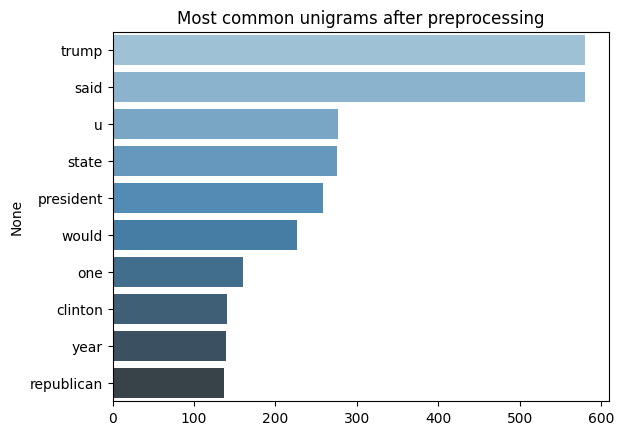

In [ ]:
sns.barplot(x=unigrams.values[:10],
            y=unigrams.index[:10],
            orient='h',
            palette='Blues_d').set(title='Most common unigrams after preprocessing')

In [ ]:
bigrams = pd.Series(nltk.ngrams(tokens_clean,2)).value_counts()
bigrams.index = bigrams.index.map(lambda x: ' '.join(x))
print(bigrams)

donald trump           113
united state            84
white house             74
president donald        47
hillary clinton         39
                      ... 
extremely concerned      1
trump extremely          1
wednesday president      1
software white           1
campus reform            1
Name: count, Length: 36973, dtype: int64


<ipython-input-90-d81646857d97>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigrams.values[:10],


[Text(0.5, 1.0, 'Most common bigrams after preprocessing')]

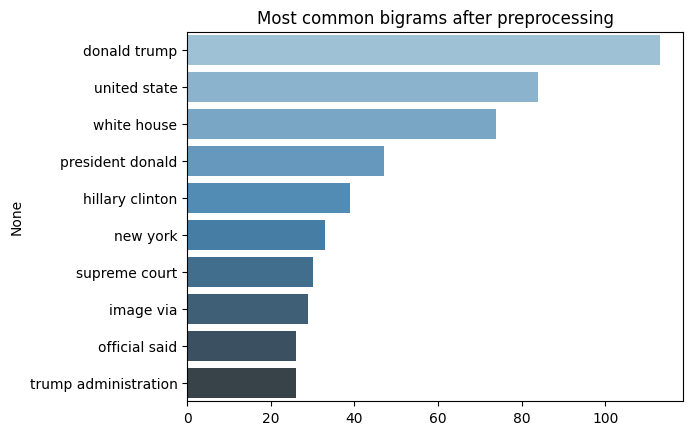

In [ ]:
sns.barplot(x=bigrams.values[:10],
            y=bigrams.index[:10],
            orient='h',
            palette='Blues_d').set(title='Most common bigrams after preprocessing')

**SENTIMENT ANALYSIS**

In [ ]:
vader_sentiment = SentimentIntensityAnalyzer()

data['vader_sentiment_score'] = data['text'].apply(lambda x : vader_sentiment.polarity_scores(x)['compound'])

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [ ]:
bins = [-1, -0.1, 0.1, 1]
labels = ['Negative','Neutral','Positive']
data['vader_sentiment'] = pd.cut(data['vader_sentiment_score'],bins=bins,labels=labels)

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,Negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive


Text(0.5, 1.0, 'Count of Article Classification')

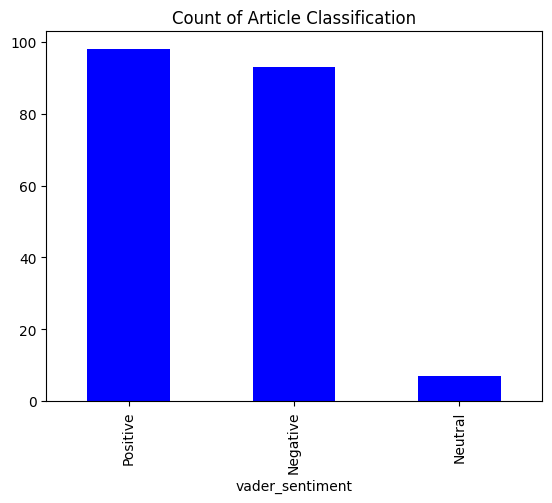

In [ ]:
data['vader_sentiment'].value_counts().plot(kind='bar',color='blue')
plt.title('Count of Article Classification')

[Text(0.5, 1.0, 'Count of Article Classification by Sentiment')]

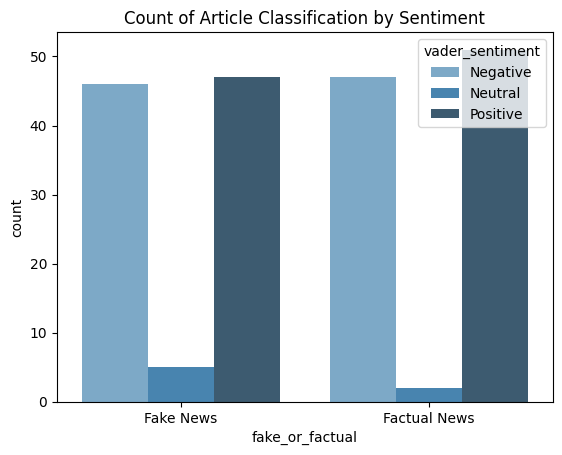

In [ ]:
sns.countplot(
    x = "fake_or_factual",
    hue = "vader_sentiment",
    data = data,
    palette = "Blues_d"
).set(title='Count of Article Classification by Sentiment')

**TOPIC MODELLING**

In [ ]:
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [ ]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [ ]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [ ]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics in range(min_topics,max_topics+1):
  model = gensim.models.LdaModel(doc_term_fake,id2word=dictionary_fake,num_topics=num_topics)
  model_list.append(model)
  coherence_model = CoherenceModel(model=model,texts=fake_news_text,dictionary=dictionary_fake,coherence='c_v')
  coherence_values.append(coherence_model.get_coherence())


Text(0, 0.5, 'Coherence Score')

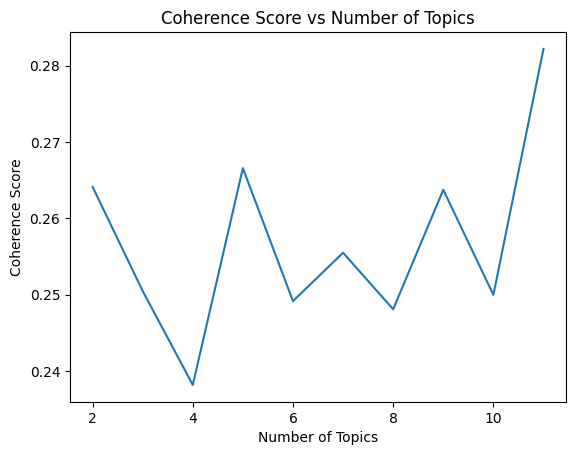

In [ ]:
plt.plot(range(min_topics,max_topics+1),coherence_values)
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')

In [ ]:
num_topics_lda = 5
lda_model = gensim.models.LdaModel(corpus=doc_term_fake,id2word=dictionary_fake,num_topics=num_topics_lda)

In [ ]:
lda_model.print_topics(num_topics = num_topics_lda,num_words = 10)

[(0,
  '0.014*"trump" + 0.006*"president" + 0.006*"said" + 0.005*"clinton" + 0.004*"one" + 0.004*"would" + 0.004*"donald" + 0.004*"state" + 0.003*"republican" + 0.003*"woman"'),
 (1,
  '0.009*"trump" + 0.005*"state" + 0.004*"u" + 0.004*"republican" + 0.004*"time" + 0.004*"said" + 0.003*"clinton" + 0.003*"president" + 0.003*"email" + 0.003*"one"'),
 (2,
  '0.007*"trump" + 0.005*"u" + 0.004*"state" + 0.003*"said" + 0.003*"would" + 0.003*"one" + 0.002*"also" + 0.002*"obama" + 0.002*"food" + 0.002*"stamp"'),
 (3,
  '0.010*"trump" + 0.005*"clinton" + 0.005*"said" + 0.005*"president" + 0.004*"year" + 0.004*"state" + 0.004*"u" + 0.004*"time" + 0.004*"would" + 0.003*"hillary"'),
 (4,
  '0.014*"trump" + 0.005*"president" + 0.004*"said" + 0.004*"would" + 0.004*"people" + 0.003*"state" + 0.003*"clinton" + 0.003*"obama" + 0.003*"one" + 0.003*"republican"')]

In [ ]:
def tfidf_corpus(doc_term_matrix):
  tfidf = TfidfModel(doc_term_matrix,normalize=True)
  corpus_tfidf = tfidf[doc_term_matrix]
  return corpus_tfidf

In [ ]:
def get_coherence_scores(corpus,dictionary,text,min_topics,max_topics):
  coherence_values = []
  model_list = []
  for num_topics_i in range(min_topics,max_topics+1):
    model = LsiModel(corpus=corpus,id2word=dictionary,num_topics=num_topics_i)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model,texts=text,dictionary=dictionary,coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
  plt.plot(range(min_topics,max_topics+1),coherence_values)
  plt.title('Coherence Score vs Number of Topics')
  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.show()

In [ ]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

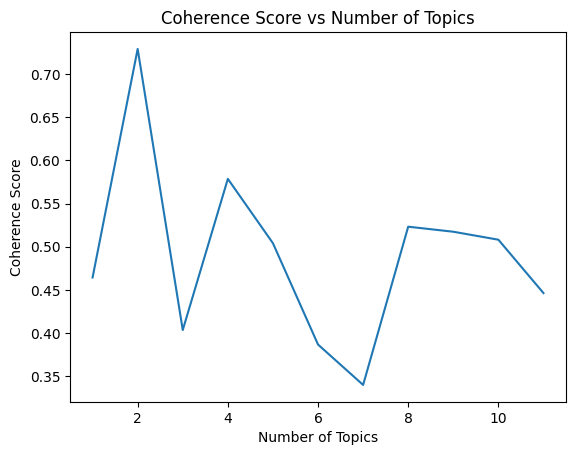

In [ ]:
get_coherence_scores(corpus_tfidf_fake,dictionary_fake,fake_news_text,1,11)

In [ ]:
lsa_model = LsiModel(corpus_tfidf_fake,id2word=dictionary_fake,num_topics=2)

In [ ]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.325*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"animal" + 0.142*"tune" + 0.134*"jay" + 0.132*"episode"')]

**Creating our Classification Model**

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,Negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive


In [ ]:
x = [','.join(map(str, l)) for l in data['text_clean']]

In [ ]:
y=data['fake_or_factual']

In [ ]:
cv=CountVectorizer()

In [ ]:
countvec_fit = cv.fit_transform(x)

In [ ]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(),columns=cv.get_feature_names_out())

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(bag_of_words,y,test_size=0.2,random_state=42)

In [ ]:
lr = LogisticRegression(random_state=0).fit(x_train,y_train)

In [ ]:
y_pred_lr = lr.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred_lr)

0.875

In [ ]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.89      0.84      0.86        19
   Fake News       0.86      0.90      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40



In [ ]:
svm = SGDClassifier().fit(x_train,y_train)

In [ ]:
y_pred_svm = svm.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred_svm)

0.875

In [ ]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.89      0.84      0.86        19
   Fake News       0.86      0.90      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

